# Test Various CNN architectures on the layer identification task


In [33]:
import torch
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix, accuracy_score

from models.utils import identify_device, test_classifier
from models.Classifier_models import CNN1D_Small, CNN1D_Large, train_model

## Import Data 

In [34]:
device = identify_device()

Using device: mps


In [35]:
# Load the dataset with weights_only=False
data = torch.load("Synthetic_data_60k.pt", weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

num_classes = int(max(num_layers)) # class labels start at 1 not 0.

Dataset loaded successfully!
Number of samples: 60000
Shape of synthetic_data: torch.Size([60000, 1024])
Shape of num_layers: torch.Size([60000])
Example number of layers: tensor([2, 1, 3, 3, 1, 3, 3, 3, 2, 2])


In [36]:
# Adjust labels for training (CrossEntropyLoss expects 0-based class labels)
num_layers_adjusted = num_layers - 1  # Convert labels from 1–5 → 0–4

# Ensure shapes are as expected
print("synthetic_data shape (after unsqueeze):", synthetic_data.unsqueeze(1).shape)
print("num_layers (original):", num_layers[:10])
print("num_layers_adjusted (for training):", num_layers_adjusted[:10])


synthetic_data shape (after unsqueeze): torch.Size([60000, 1, 1024])
num_layers (original): tensor([2, 1, 3, 3, 1, 3, 3, 3, 2, 2])
num_layers_adjusted (for training): tensor([1, 0, 2, 2, 0, 2, 2, 2, 1, 1])


In [37]:
# Dataset parameters
num_classes = int(num_layers_adjusted.max().item()) + 1  # e.g., 5 if max label is 4
batch_size = 256
val_ratio = 0.2  # 20% of the data for validation

# Add channel dimension for Conv1D input: [B, 1, 1024]
synthetic_data = synthetic_data.unsqueeze(1)  # [N, 1, 1024]

# Create TensorDataset
full_dataset = TensorDataset(synthetic_data, num_layers_adjusted)

# Split into train and validation sets
total_size = len(full_dataset)
val_size = int(val_ratio * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Train and Test Small CNN

In [38]:
model_summary = CNN1D_Small()
summary(model_summary, input_size=(1, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 1024]             192
         MaxPool1d-2              [-1, 32, 512]               0
            Conv1d-3              [-1, 64, 512]          10,304
         MaxPool1d-4              [-1, 64, 256]               0
            Conv1d-5             [-1, 128, 256]          41,088
            Linear-6                   [-1, 64]           8,256
           Dropout-7                   [-1, 64]               0
            Linear-8                    [-1, 3]             195
Total params: 60,035
Trainable params: 60,035
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.00
Params size (MB): 0.23
Estimated Total Size (MB): 1.23
----------------------------------------------------------------


In [39]:
# Initialize the model, criterion, and optimizer
model = CNN1D_Small(input_channels=1, num_classes=num_classes).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Optional: Print shapes and label stats for sanity check
print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([60000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


In [40]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

train_loss, train_acc, val_loss, val_acc, lr_vals = train_model(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=150,
    verbose='batch'
)

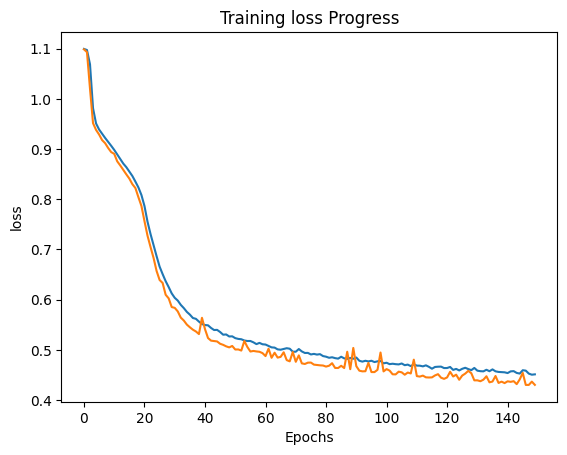

In [41]:
# Plot the acuracy values
plt.plot(train_loss, label='training')
plt.plot(val_loss, label='validation')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Training loss Progress')
plt.show()

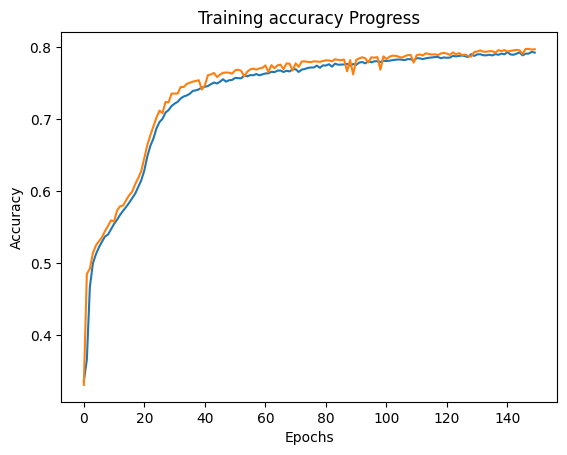

In [42]:
# Plot the acuracy values
plt.plot(train_acc, label='training')
plt.plot(val_acc, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy Progress')
plt.show()

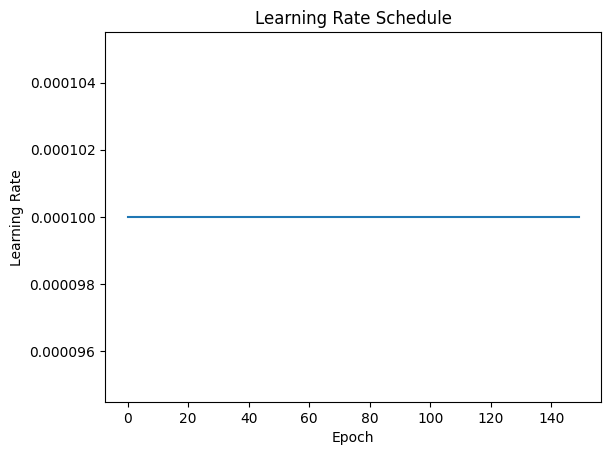

In [43]:
plt.plot(lr_vals)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()


 Unseen dataset Accuracy: 0.7887


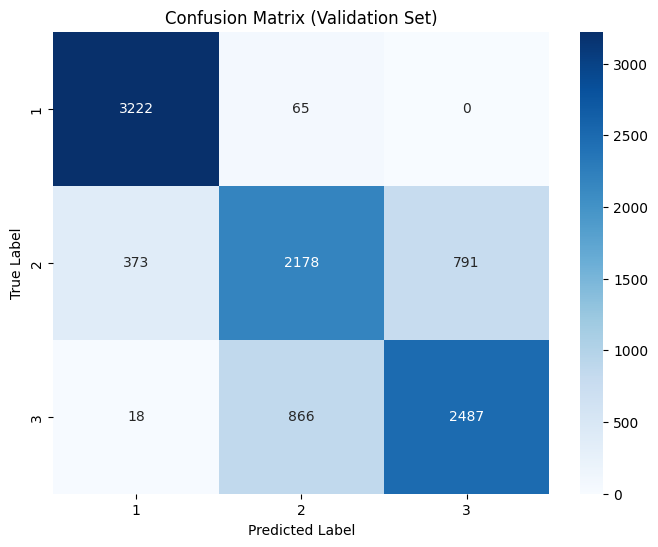

In [44]:
test_classifier(model, 'Validation.pt', device)

## Train and test Larger CNN

In [25]:
model_summary_large = CNN1D_Large()
summary(model_summary_large, input_size=(1, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 1024]             384
         GroupNorm-2             [-1, 64, 1024]             128
         MaxPool1d-3              [-1, 64, 512]               0
            Conv1d-4             [-1, 128, 512]          41,088
         GroupNorm-5             [-1, 128, 512]             256
         MaxPool1d-6             [-1, 128, 256]               0
            Conv1d-7             [-1, 256, 256]          98,560
         GroupNorm-8             [-1, 256, 256]             512
         MaxPool1d-9             [-1, 256, 128]               0
           Conv1d-10             [-1, 256, 128]         196,864
        GroupNorm-11             [-1, 256, 128]             512
        MaxPool1d-12              [-1, 256, 64]               0
AdaptiveAvgPool1d-13               [-1, 256, 1]               0
           Linear-14                   

In [26]:
batch_size = 128
val_ratio = 0.2  

# Split into train and validation sets
total_size = len(full_dataset)
val_size = int(val_ratio * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [27]:
# Initialize the model, criterion, and optimizer
model = CNN1D_Large(input_channels=1, num_classes=num_classes).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([60000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


In [28]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

train_loss, train_acc, val_loss, val_acc, lr_vals = train_model(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=100,
    verbose='epoch'
)

Training epochs: 100%|██████████| 100/100 [36:34<00:00, 21.94s/epoch]


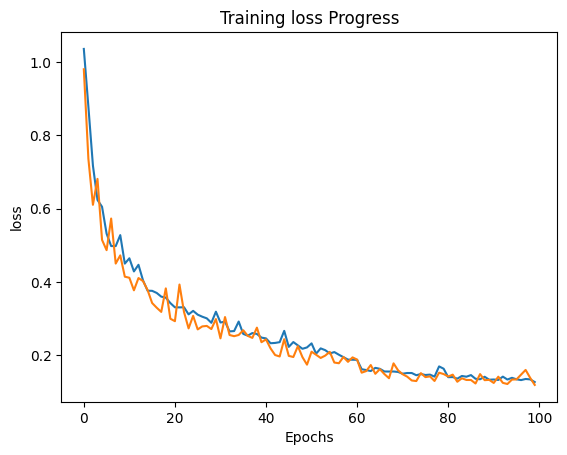

In [29]:
# Plot the acuracy values
plt.plot(train_loss, label='training')
plt.plot(val_loss, label='validation')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Training loss Progress')
plt.show()

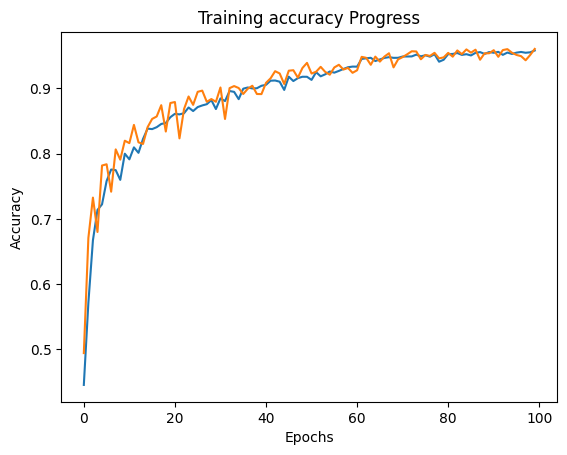

In [30]:
# Plot the accuracy values
plt.plot(train_acc, label='training')
plt.plot(val_acc, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy Progress')
plt.show()

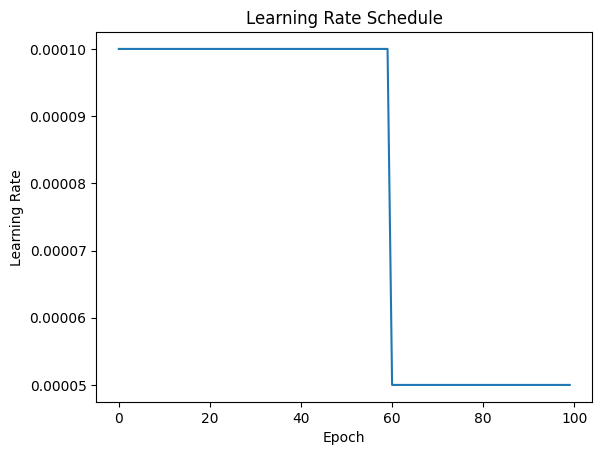

In [31]:
plt.plot(lr_vals)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()


Unseen Accuracy: 0.9576


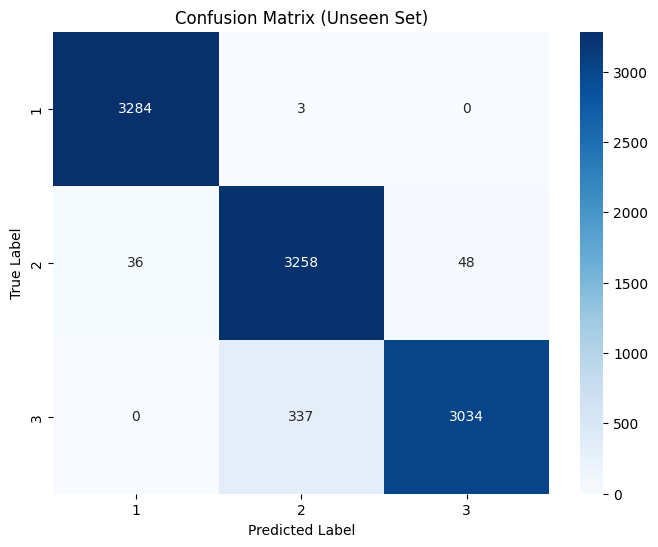

In [32]:
test_classifier(model, 'Validation.pt', device)

In [ ]:
test_classifier(model, 'Validation_noise_1eneg3.pt', device)

In [ ]:
test_classifier(model, 'Validation_noise_1eneg4.pt', device)